In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_size = 256
BATCH_size = 32
CHANNELS = 3
EPOCHS = 75

In [3]:
# This API used to load all the Images from our directory to the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_size,IMAGE_size),
    batch_size = BATCH_size
)

Found 16011 files belonging to 10 classes.


In [4]:
# class names are the sub directory names inside the main directory"PlantVillage"
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

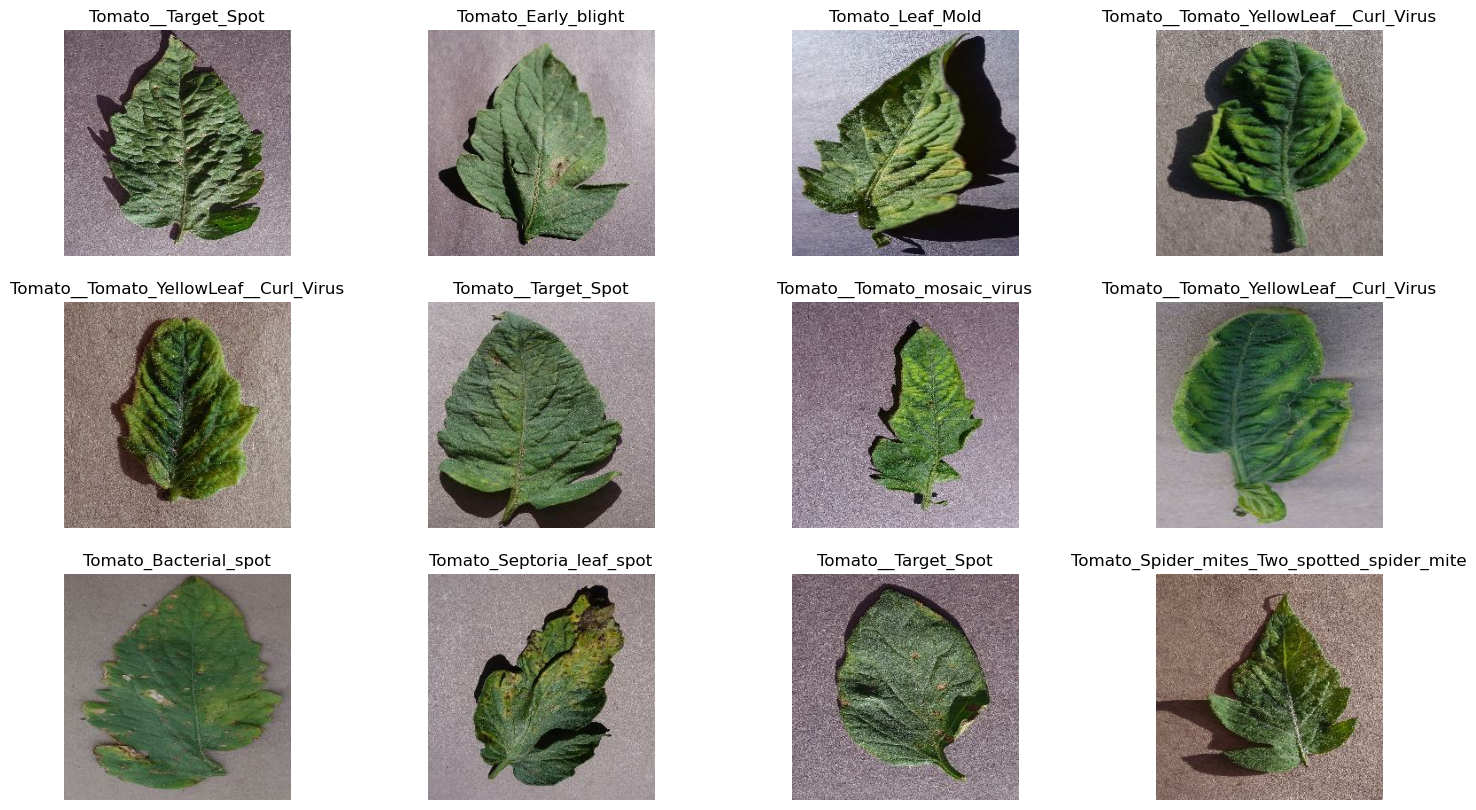

In [5]:
# visualising the image data in the dataset
plt.figure(figsize = (18, 10))
for img_batch, lable_batch in dataset.take(1):
    for i in range(12):
        img = plt.subplot(3,4,i+1)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.title(class_names[lable_batch[i]])
        plt.axis("off")

In [6]:
len(dataset)

501

In [7]:
''' split the dataset into three parts: 
    80% = training data, 
    10% = validation at every end of the epoch,
    10% = testing''' 
# Function to split the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, shuffle_size=20000):
    
    ds_size = len(ds)                                 # size of total dataset
    
    if shuffle:                                       
        ds = ds.shuffle(shuffle_size, seed=12)        # for predictability we use seed
    
    train_size = int(train_split * ds_size)           # size of training dataset
    validation_size = int(validation_split * ds_size) # size of validation dataset
    
    train_ds = ds.take(train_size)                    # training data
    validation_ds = ds.skip(train_size).take(validation_size)# validating data
    test_ds = ds.skip(train_size).skip(validation_size)      # testing data
    
    return train_ds, validation_ds, test_ds

In [8]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

400

In [10]:
len(validation_ds)

50

In [11]:
len(test_ds)

51

In [12]:
# chache : cache a dataset, either in memory or on local storage. This will save some operations (file opening and reading) from being executed during each epoch.
# prefetch : While the model is executing training step s , the input pipeline is reading the data for step s+1 
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# data preprocessing:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_size, IMAGE_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
# data augmentation:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
# CNN architecture:
# Convolutional layer -> pooling layer -> con layer -> pool layer ......-> flatten layer -> dense network layer 
input_shape = (BATCH_size, IMAGE_size, IMAGE_size, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [16]:
model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [17]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [18]:
# train the CNN
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_size,
    verbose = 1,
    validation_data = validation_ds
)

Epoch 1/75
400/400 [==============================] - 856s 2s/step - loss: 1.6652 - accuracy: 0.4023 - val_loss: 1.3233 - val_accuracy: 0.4963
Epoch 2/75
400/400 [==============================] - 722s 2s/step - loss: 1.1140 - accuracy: 0.6075 - val_loss: 0.8697 - val_accuracy: 0.6925
Epoch 3/75
400/400 [==============================] - 729s 2s/step - loss: 0.7426 - accuracy: 0.7377 - val_loss: 0.7240 - val_accuracy: 0.7319
Epoch 4/75
400/400 [==============================] - 722s 2s/step - loss: 0.5500 - accuracy: 0.8053 - val_loss: 0.6699 - val_accuracy: 0.7588
Epoch 5/75
400/400 [==============================] - 721s 2s/step - loss: 0.4861 - accuracy: 0.8299 - val_loss: 0.9930 - val_accuracy: 0.7119
Epoch 6/75
400/400 [==============================] - 712s 2s/step - loss: 0.3987 - accuracy: 0.8598 - val_loss: 0.5944 - val_accuracy: 0.8062
Epoch 7/75
400/400 [==============================] - 731s 2s/step - loss: 0.3487 - accuracy: 0.8760 - val_loss: 0.3645 - val_accuracy: 0.8750

Epoch 58/75
400/400 [==============================] - 732s 2s/step - loss: 0.0766 - accuracy: 0.9754 - val_loss: 0.0711 - val_accuracy: 0.9731
Epoch 59/75
400/400 [==============================] - 739s 2s/step - loss: 0.0635 - accuracy: 0.9782 - val_loss: 0.0989 - val_accuracy: 0.9700
Epoch 60/75
400/400 [==============================] - 743s 2s/step - loss: 0.0679 - accuracy: 0.9775 - val_loss: 0.1294 - val_accuracy: 0.9550
Epoch 61/75
400/400 [==============================] - 740s 2s/step - loss: 0.0632 - accuracy: 0.9787 - val_loss: 0.1422 - val_accuracy: 0.9531
Epoch 62/75
400/400 [==============================] - 759s 2s/step - loss: 0.0763 - accuracy: 0.9752 - val_loss: 0.1815 - val_accuracy: 0.9519
Epoch 63/75
400/400 [==============================] - 757s 2s/step - loss: 0.0648 - accuracy: 0.9791 - val_loss: 0.0743 - val_accuracy: 0.9731
Epoch 64/75
400/400 [==============================] - 733s 2s/step - loss: 0.0721 - accuracy: 0.9751 - val_loss: 0.0845 - val_accuracy:

In [19]:
# testing the model
scores = model.evaluate(test_ds)

51/51 [==============================] - 106s 484ms/step - loss: 0.0486 - accuracy: 0.9822


In [20]:
#[loss, accuracy]
scores

[0.04860876128077507, 0.9822303652763367]

In [21]:
# data on trained model history(variable)
history.params

{'verbose': 1, 'epochs': 75, 'steps': 400}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
# Visualizations the data in the trained model
Accuracy = history.history['accuracy']
Validation_Accuracy = history.history['val_accuracy']

Loss = history.history['loss']
Validation_Loss = history.history['val_loss']

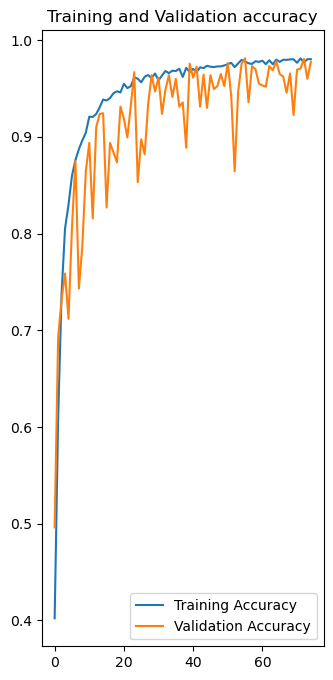

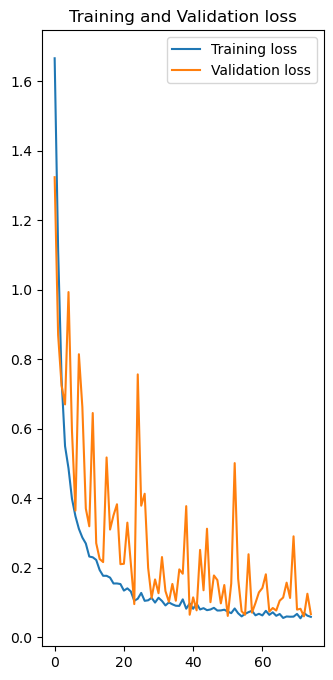

In [44]:
# chart for Training and Validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), Accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), Validation_Accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

# chart for Training and Validation loss
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), Loss, label='Training loss')
plt.plot(range(EPOCHS), Validation_Loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

Image to predict
Actual label: Tomato_Septoria_leaf_spot
1/1 [==============================] - 0s 287ms/step
predicted label: Tomato_Septoria_leaf_spot


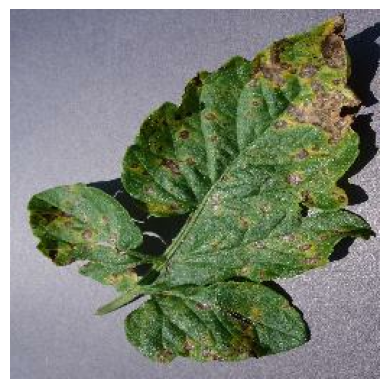

In [40]:
# Make prediction / inference on sample image:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    # input image label (actual image label)
    print("Image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    # predicted label
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [47]:
# check the confidence of the model
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) 
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


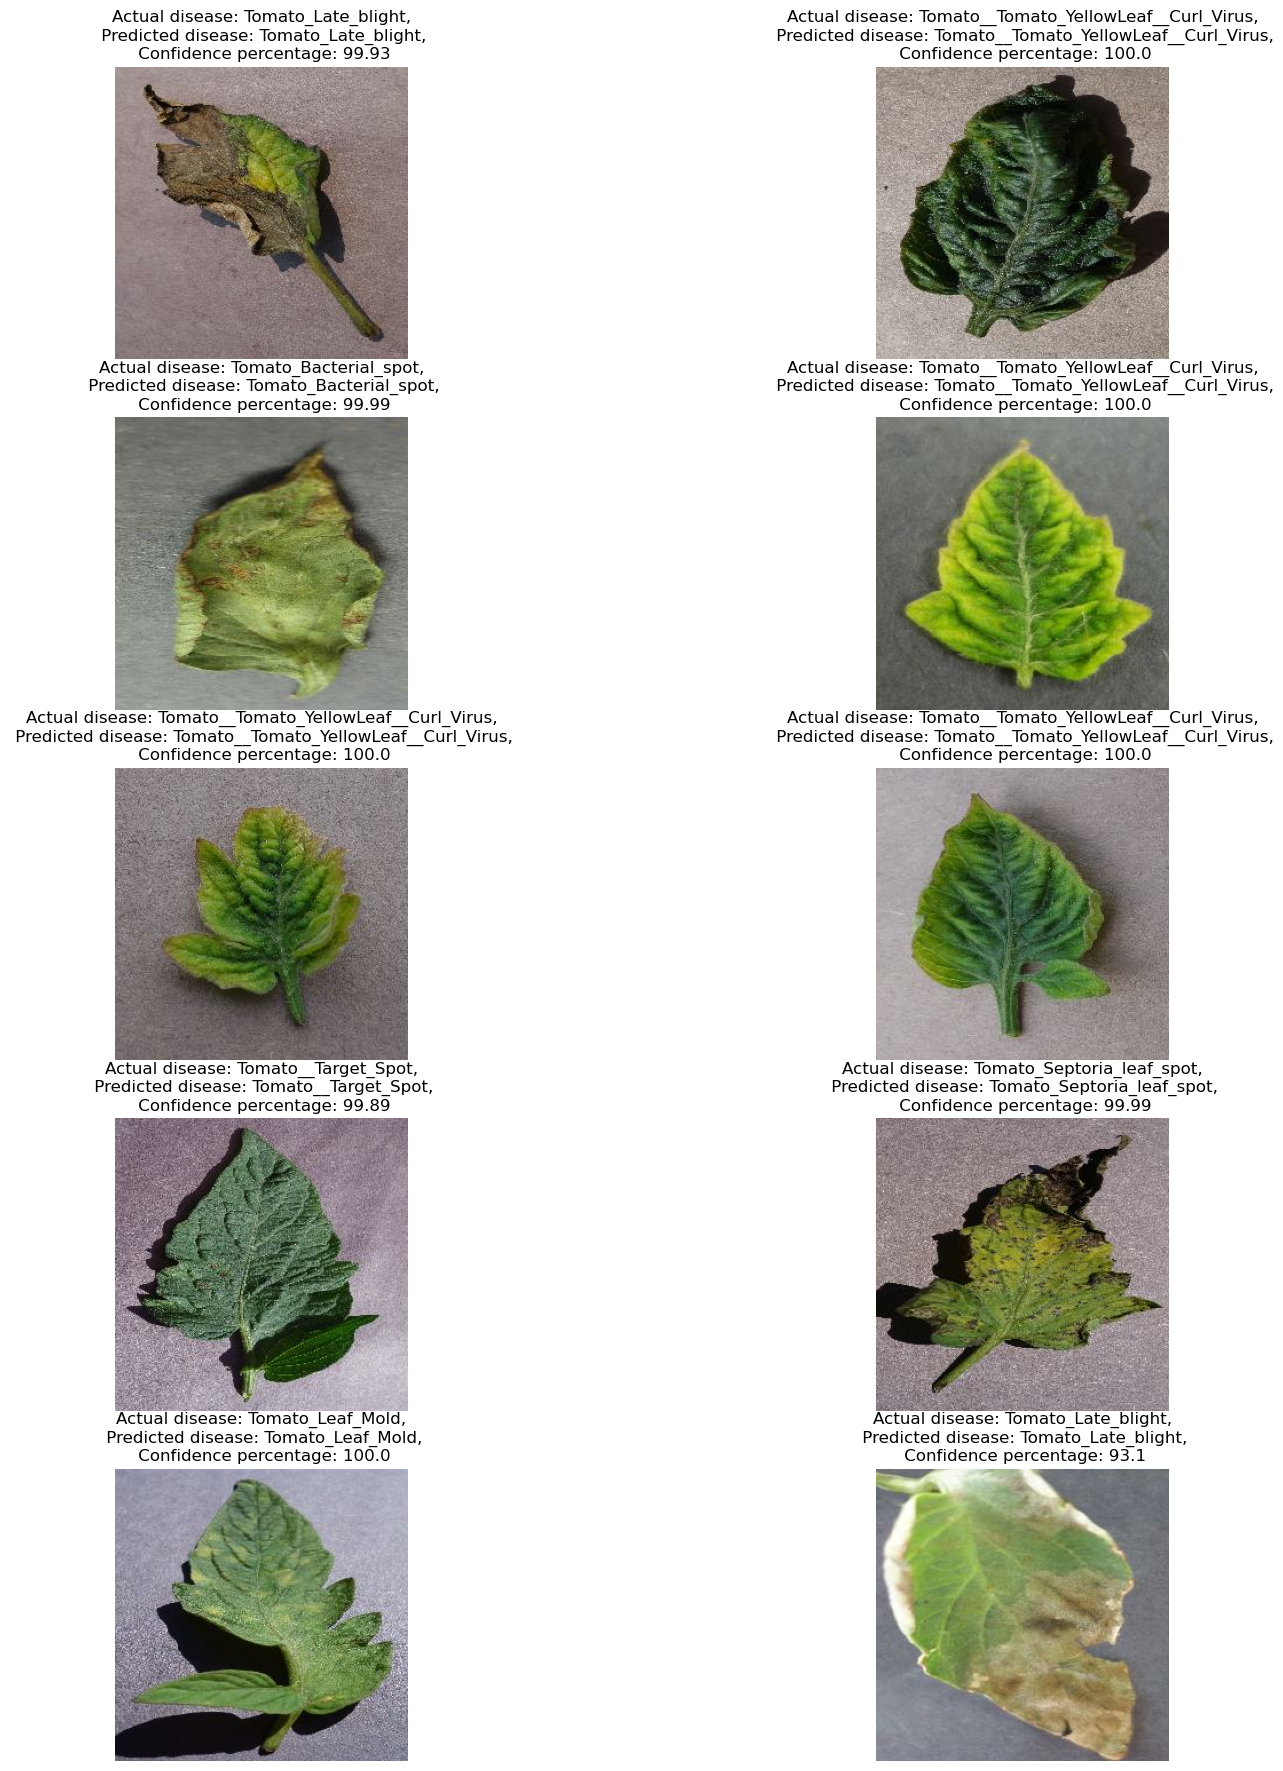

In [54]:
plt.figure(figsize=(18, 22))
for images, labels in test_ds.take(1):
    for i in range(10):
        ax = plt.subplot(5,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual disease: {actual_class},\n Predicted disease: {predicted_class},\n Confidence percentage: {confidence}")
        
        plt.axis("off")

In [64]:
# Exporting model to a separate directory
"""
manual export method: 
model_version = "name of the file"
model.save(f"../Trained_models/{model_version}")
"""
# automated method: [the filename is the version_number]
import os
model_version = max([int(i) for i in os.listdir("../Trained_models")+[0]])+1
model.save(f"../Trained_models/{model_version}")  

INFO:tensorflow:Assets written to: ../Trained_models/2\assets


INFO:tensorflow:Assets written to: ../Trained_models/2\assets
